# NASA Defects - Model Building

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "US_Churn"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = False
SEED = 1612

In [2]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")
        d = "/content/gdrive/MyDrive/datasets"
        if not os.path.isdir(d): os.makedirs(d)
        if not os.path.isdir(ROOT): os.makedirs(ROOT)

def makedirs(d):
    if COLAB:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
    else:
        if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Dataset

In [3]:
df = pd.read_csv(f"{ROOT}/data/pc2.csv")
print(df.shape)
df.head(5)

(933, 37)


,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,DESIGN_COMPLEXITY,DESIGN_DENSITY,EDGE_COUNT,ESSENTIAL_COMPLEXITY,ESSENTIAL_DENSITY,LOC_EXECUTABLE,PARAMETER_COUNT,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,MAINTENANCE_SEVERITY,MODIFIED_CONDITION_COUNT,MULTIPLE_CONDITION_COUNT,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defects
0,1.0,4.0,7.0,24.0,0.0,1.0,0.13,0.0,0.0,1.0,1.00,6.0,1.0,0.0,1.0,0.0,17.88,7.43,986.77,0.04,34.0,0.13,54.82,132.83,1.0,0.0,0.0,7.0,0.03,13.0,21.0,7.0,8.0,34.0,96.88,8.0,False
1,1.0,1.0,11.0,3.0,0.0,1.0,0.08,0.0,0.0,1.0,1.00,2.0,1.0,0.0,1.0,0.0,42.62,7.81,2598.31,0.11,77.0,0.13,144.35,332.79,1.0,0.0,0.0,3.0,0.06,29.0,48.0,13.0,7.0,17.0,93.33,12.0,False
2,5.0,1.0,9.0,10.0,6.0,3.0,0.25,2.0,3.0,2.0,0.67,9.0,3.0,1.0,3.0,3.0,15.53,18.90,5545.97,0.10,64.0,0.05,308.11,293.44,1.0,2.0,3.0,8.0,0.13,27.0,37.0,10.0,14.0,24.0,86.36,12.0,False
3,1.0,0.0,3.0,5.0,0.0,1.0,0.25,0.0,0.0,1.0,1.00,1.0,1.0,0.0,1.0,1.0,20.84,3.94,323.05,0.03,21.0,0.25,17.95,82.04,1.0,0.0,0.0,2.0,0.09,9.0,12.0,8.0,7.0,11.0,88.89,4.0,False
4,3.0,0.0,1.0,0.0,4.0,2.0,1.00,2.0,2.0,1.0,0.50,7.0,1.0,0.0,1.0,3.0,11.42,6.67,507.65,0.03,20.0,0.15,28.20,76.15,0.5,1.0,2.0,7.0,0.50,10.0,10.0,6.0,8.0,4.0,50.00,2.0,False


## Target and Features

In [4]:
target = "defects"
features = [c for c in df.columns if c not in target]

num_features = len(features)

print(f"Traget: {target}")
print(f"Features: {features}")

Traget: defects
Features: ['BRANCH_COUNT', 'CALL_PAIRS', 'LOC_CODE_AND_COMMENT', 'LOC_COMMENTS', 'CONDITION_COUNT', 'CYCLOMATIC_COMPLEXITY', 'CYCLOMATIC_DENSITY', 'DECISION_COUNT', 'DECISION_DENSITY', 'DESIGN_COMPLEXITY', 'DESIGN_DENSITY', 'EDGE_COUNT', 'ESSENTIAL_COMPLEXITY', 'ESSENTIAL_DENSITY', 'LOC_EXECUTABLE', 'PARAMETER_COUNT', 'HALSTEAD_CONTENT', 'HALSTEAD_DIFFICULTY', 'HALSTEAD_EFFORT', 'HALSTEAD_ERROR_EST', 'HALSTEAD_LENGTH', 'HALSTEAD_LEVEL', 'HALSTEAD_PROG_TIME', 'HALSTEAD_VOLUME', 'MAINTENANCE_SEVERITY', 'MODIFIED_CONDITION_COUNT', 'MULTIPLE_CONDITION_COUNT', 'NODE_COUNT', 'NORMALIZED_CYLOMATIC_COMPLEXITY', 'NUM_OPERANDS', 'NUM_OPERATORS', 'NUM_UNIQUE_OPERANDS', 'NUM_UNIQUE_OPERATORS', 'NUMBER_OF_LINES', 'PERCENT_COMMENTS', 'LOC_TOTAL']


### Check target values

In [5]:
df[target].value_counts(normalize=True)

False    0.975348
True     0.024652
Name: defects, dtype: float64

##### Comments
- From the relative frequencies above we can see clearly that the dataset is unbalanced.
- We will attempt to use a Synthetic Minority Oversampling Technique (SMOTE) to balance out the dataset.

## SMOTE

### Imports for SMOTE

In [6]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

### Create a synthetic binary classification dataset

In [7]:
X, y = make_classification(n_samples=933, n_features=36, n_redundant=0, n_clusters_per_class=1, weights=[0.975], flip_y=0, random_state=SEED)

### Summarize class distribution

In [8]:
counter = Counter(y)
print(counter)

Counter({0: 910, 1: 23})


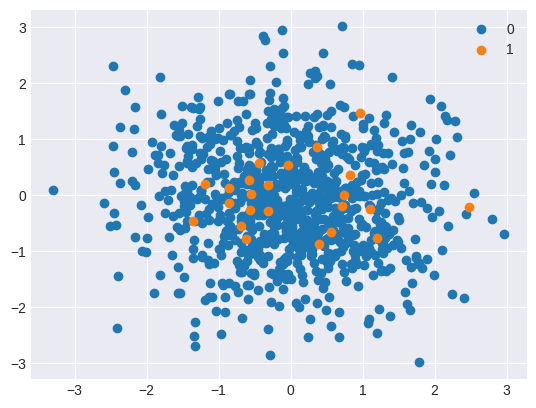

In [9]:
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

### Define pipeline

In [10]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

### Transform the dataset

In [11]:
X, y = pipeline.fit_resample(X, y)

### Summarize the new class distribution

In [12]:
counter = Counter(y)
print(counter)

Counter({0: 182, 1: 91})


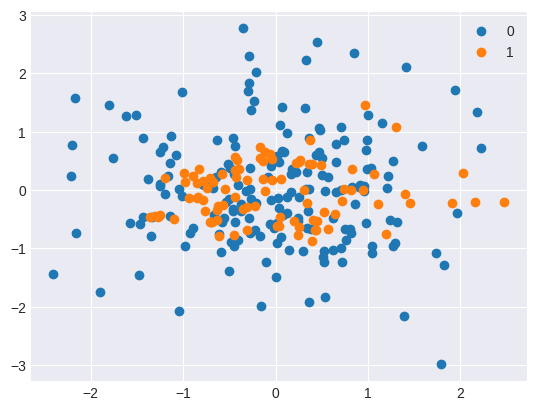

In [13]:
for label, _ in counter.items():
 row_ix = where(y == label)[0]
 plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

## Feature Engineering

#### Train test split

In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify=df[target], test_size=.40, random_state=SEED)

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,features].values)
y_train = df_train.defects.values

X_test = scaler.transform(df_test.loc[:,features].values)
y_test = df_test.defects.values

#### Applying smote

In [16]:
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/PStefans/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


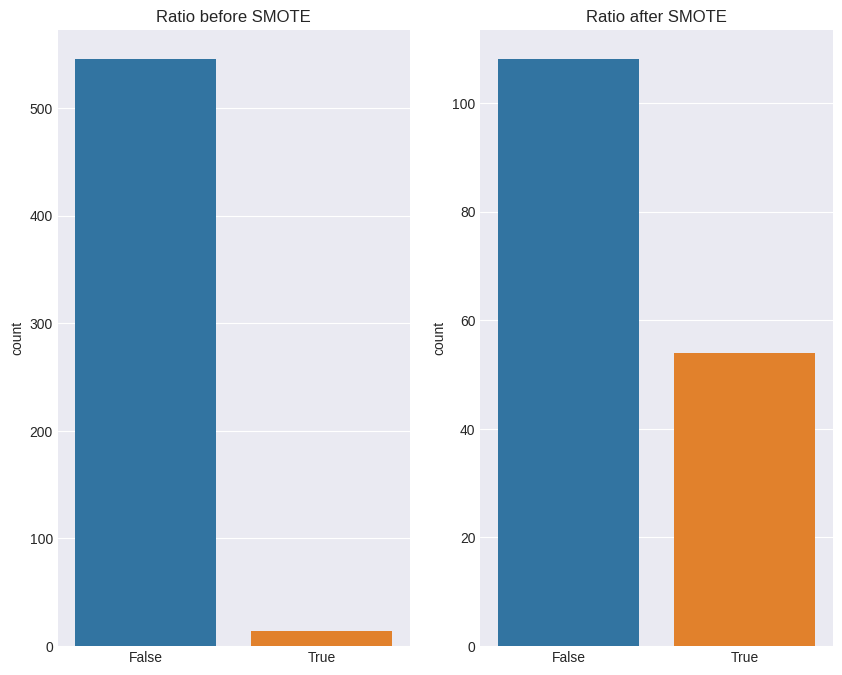

In [17]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Ratio before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Ratio after SMOTE')
plt.show()

### Model Selection

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
}

def train_models():
    best = {'name':None, 'mean':0}
    
    for name,model in models.items():
    
        scores = cross_val_score(model, X_smote, y_smote, scoring='accuracy', cv=10)
        mean = scores.mean()
        std = scores.std()
        
        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")
    
        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) accuracy = {best['mean']:.2%}" )
    

In [19]:
train_models()


Model LR
	CV scores: 0.82, 0.59, 0.88, 0.75, 0.69, 0.81, 0.81, 0.94, 0.94, 1.00
	mean=82.24% std=0.1180

Model DT
	CV scores: 0.94, 0.71, 0.88, 0.94, 1.00, 0.88, 1.00, 0.81, 1.00, 0.81
	mean=89.60% std=0.0934

Model DT(max_depth=3)
	CV scores: 0.88, 0.76, 0.88, 0.88, 1.00, 0.88, 1.00, 0.88, 1.00, 0.94
	mean=90.85% std=0.0720

Model KNN
	CV scores: 0.88, 0.65, 0.88, 0.81, 0.81, 0.81, 0.94, 1.00, 0.75, 1.00
	mean=85.29% std=0.1047

Model SVC
	CV scores: 0.88, 0.65, 0.81, 0.75, 0.88, 0.81, 0.81, 0.88, 0.94, 0.88
	mean=82.79% std=0.0782

Best Performing Model DT(max_depth=3) with (mean CV of) accuracy = 90.85%


### Feature Selection

In [20]:
print("Number of features starting:", len(features))

Number of features starting: 36


Optimal number of features : 8


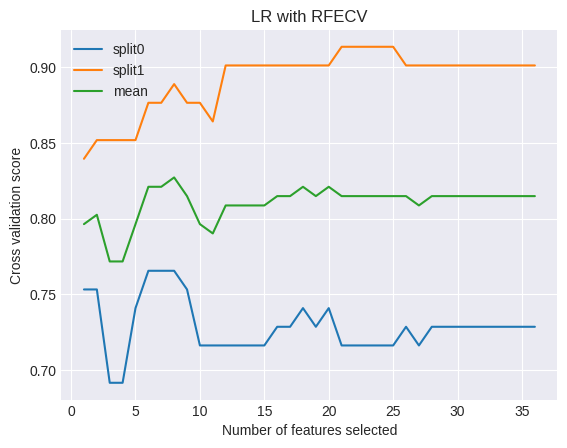

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="accuracy")
rfecv.fit(X_smote, y_smote)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [22]:
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['CALL_PAIRS',
 'CONDITION_COUNT',
 'DECISION_COUNT',
 'DESIGN_COMPLEXITY',
 'LOC_EXECUTABLE',
 'MULTIPLE_CONDITION_COUNT',
 'NORMALIZED_CYLOMATIC_COMPLEXITY',
 'PERCENT_COMMENTS']

#### Comment
- When runing this without SMOTE the optimal number of features was one (percent_comment)
- After applying smote we can see that the optimal 

#### Training - After feature selection

In [23]:
display(df.loc[:, features_selected + [target]].head(1))

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,features_selected].values)
y_train = df_train.defects.values
X_test = scaler.fit_transform(df_test.loc[:,features_selected].values)
y_test = df_test.defects.values

# apply smote
X_smote, y_smote = pipeline.fit_resample(X_train, y_train)

train_models()

,CALL_PAIRS,CONDITION_COUNT,DECISION_COUNT,DESIGN_COMPLEXITY,LOC_EXECUTABLE,MULTIPLE_CONDITION_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,PERCENT_COMMENTS,defects
0,4.0,0.0,0.0,1.0,1.0,0.0,0.03,96.88,False



Model LR
	CV scores: 1.00, 0.76, 0.69, 0.81, 1.00, 0.88, 0.69, 0.81, 0.75, 0.75
	mean=81.40% std=0.1075

Model DT
	CV scores: 0.88, 0.71, 0.69, 0.94, 0.88, 0.94, 0.81, 0.69, 0.94, 0.94
	mean=84.01% std=0.1031

Model DT(max_depth=3)
	CV scores: 0.76, 0.65, 0.56, 0.88, 0.81, 1.00, 0.62, 0.69, 0.81, 0.88
	mean=76.62% std=0.1282

Model KNN
	CV scores: 0.88, 0.59, 0.75, 0.81, 0.81, 0.94, 0.69, 0.69, 0.75, 0.88
	mean=77.83% std=0.1010

Model SVC
	CV scores: 0.76, 0.59, 0.69, 0.88, 0.88, 1.00, 0.88, 0.69, 0.81, 0.94
	mean=81.03% std=0.1209

Best Performing Model DT with (mean CV of) accuracy = 84.01%
